# Lesson 8 - Part 02

This is a reimplementation of fastai part 2 version 3 in Swift.
https://github.com/fastai/fastai_docs/blob/master/dev_course/dl2/02_fully_connected.ipynb

note: this requires my fork of [swift-jupyter](https://github.com/metachi/swift-jupyter) and a clone of my [TimeMagic](https://github.com/metachi/TimeMagic) repo for the ```%%time``` and ```%%timeit``` magic commands to work

In [1]:
%install '.package(path: "~/gitrepos/TimeMagic")' TimeMagic
%install '.package(url: "https://github.com/mxcl/Path.swift", from: "0.16.1")' Path
%install '.package(url: "https://github.com/JustHTTP/Just", from: "0.7.1")' Just

Installing packages:
	.package(path: "~/gitrepos/TimeMagic")
		TimeMagic
	.package(url: "https://github.com/mxcl/Path.swift", from: "0.16.1")
		Path
	.package(url: "https://github.com/JustHTTP/Just", from: "0.7.1")
		Just
Fetching https://github.com/mxcl/Path.swift
Fetching https://github.com/JustHTTP/Just
Completed resolution in 1.43s
Cloning https://github.com/mxcl/Path.swift
Resolving https://github.com/mxcl/Path.swift at 0.16.2
Cloning https://github.com/JustHTTP/Just
Resolving https://github.com/JustHTTP/Just at 0.7.1
Compile Swift Module 'TimeMagic' (1 sources)
Compile Swift Module 'Just' (1 sources)
Compile Swift Module 'Path' (9 sources)
Compile Swift Module 'jupyterInstalledPackages' (1 sources)
Linking ./.build/x86_64-unknown-linux/debug/libjupyterInstalledPackages.so
Installation complete!

In [2]:
import TimeMagic
import Foundation
import Path
import Just

### Download Dataset

In [3]:
print(Path.home/".fastai"/"data"/"test.txt")

/home/jeff/.fastai/data/test.txt


In [4]:
public func download(_ url: String, dest: String){
    let r = Just.get(url, allowRedirects:false)
    do {
        try r.content!.write(to: URL.init(fileURLWithPath: dest))
    } catch {
        print("error downloading \(url)")
    }
}

In [5]:
let base = "http://yann.lecun.com/exdb/mnist/"
let trn_imgs = "train-images-idx3-ubyte"
let trn_lbls = "train-labels-idx1-ubyte"
let val_imgs = "t10k-images-idx3-ubyte"
let val_lbls = "t10k-labels-idx1-ubyte" 

In [6]:
let dest = Path.home/".fastai"/"data"/"mnist"

In [7]:
if !dest.exists{
    dest.mkdir()
}

In [8]:
for fileName in [trn_imgs, trn_lbls, val_imgs, val_lbls] {
    var destPath = dest/(fileName)
    if !destPath.exists{
        download("\(base)/\(fileName)", dest: destPath.string + ".gz")
    }
}

In [9]:
for n in dest.ls() {
    print(n.path)
}

/home/jeff/.fastai/data/mnist/t10k-labels-idx1-ubyte
/home/jeff/.fastai/data/mnist/train-labels-idx1-ubyte
/home/jeff/.fastai/data/mnist/train-images-idx3-ubyte
/home/jeff/.fastai/data/mnist/t10k-images-idx3-ubyte


gunzip the files

In [10]:
for n in dest.ls() {
    print(n.path)
}

/home/jeff/.fastai/data/mnist/t10k-labels-idx1-ubyte
/home/jeff/.fastai/data/mnist/train-labels-idx1-ubyte
/home/jeff/.fastai/data/mnist/train-images-idx3-ubyte
/home/jeff/.fastai/data/mnist/t10k-images-idx3-ubyte


### Load the dataset

In [11]:
import TensorFlow

See [Yann Lecunn's site](http://yann.lecun.com/exdb/mnist/) for info on why we have to drop the first few k bits.  See the "TRAINING SET LABEL FILE" heading and similarly named headings.

In [12]:
func loadData(path: String, shape: [Int32], is_label: Bool) -> Tensor<Float> {
    let dropK: Int = (is_label ? 8 : 16)
    let data = try! Data.init(contentsOf: 
                     URL.init(fileURLWithPath: path)
                    ).dropFirst(dropK)
    let tensorShape = TensorShape.init(shape)
    return Tensor(data.map(Float.init)).reshaped(to: tensorShape)
}

In [13]:
var xTrain: Tensor<Float> = loadData(path: (dest/trn_imgs).string,
                   shape: [60000, 784],
                   is_label: false)/255

In [14]:
let yTrain: Tensor<Float> = loadData(path: (dest/trn_lbls).string,
                   shape: [60000],
                   is_label: true)

In [15]:
var xValid: Tensor<Float> = loadData(path: (dest/val_imgs).string,
                   shape: [10000, 784],
                   is_label: false)/255

In [16]:
let yValid: Tensor<Float> = loadData(path: (dest/val_lbls).string,
                   shape: [10000],
                   is_label: true)

In [17]:
import Python

In [18]:
let np = Python.import("numpy")
let plt = Python.import("matplotlib.pyplot")

In [19]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [20]:
let img = np.array(xTrain[0].array.scalars).reshape(28,28)

Label: 5.0


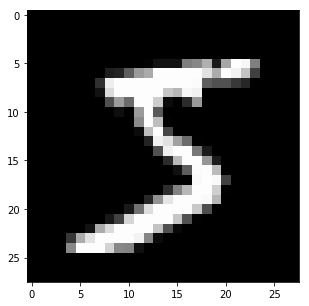

In [21]:
plt.figure(figsize: [5,5])
let fig = plt.imshow(X:img, cmap:"gray")
plt.show(fig)
print("Label: \(yTrain[0])")

### The forward and backward passes

In [21]:
public extension Tensor where Scalar : FloatingPoint {
    func stddev(alongAxes axes: [Int32])-> Tensor<Scalar>{
        let mean = self.mean(alongAxes: axes)
        return sqrt((self - mean).squared().mean(alongAxes: axes))
    }
    
    func stddev()-> Tensor<Scalar>{
        let mean = self.mean()
        return sqrt((self - mean).squared().mean())
    }
}

In [23]:
func normalize<Scalar: FloatingPoint>(_ x: Tensor<Scalar>, _ mean: Tensor<Scalar>? = nil, _ stddev: Tensor<Scalar>? = nil) ->  Tensor<Scalar>{
    var mean = (mean ?? x.mean())
    var stddev = (stddev ?? x.stddev())
    return (x-mean)/stddev
}

In [24]:
var xTrainNormal: Tensor<Float> = normalize(xTrain)
var xValidNormal: Tensor<Float> = normalize(xValid,
                                            xTrain.mean(),
                                            sqrt(xTrain.variance(alongAxes: [0,1]))
                                           )

In [25]:
func almostEqual<Scalar: SignedNumeric & FloatingPoint>(_ x: Tensor<Scalar>, _ y: Tensor<Scalar>, _ tolerance: Tensor<Scalar>) -> Bool{
    return (abs(x - y) .< tolerance).all()
}

In [26]:
print(xTrainNormal.mean(), xTrainNormal.variance(alongAxes: [0,1]))

-1.4449139e-08 [[1.0000017]]


In [27]:
almostEqual(xTrainNormal.mean(), Tensor(0), Tensor(1e-3))

true


In [28]:
almostEqual(sqrt(xTrainNormal.variance(alongAxes: [0,1])),
            Tensor(1),
            Tensor(1e-3))

true


This should be near 0,1

In [29]:
print(xValidNormal.mean(), xValidNormal.variance(alongAxes: [0,1]))

0.0060177604 [[1.0154601]]


In [30]:
almostEqual(xValidNormal.mean(), Tensor(0), Tensor(1e-2))

true


In [31]:
almostEqual(sqrt(xValidNormal.variance(alongAxes: [0,1])),
            Tensor(1),
            Tensor(1e-2))

true


In [32]:
var shp = xTrainNormal.shape
let n = shp[0]
let m = shp[1]
let c = yTrain.max() + 1
print(n, m, c)

60000 784 10.0


## Foundations version

### Basic architecture

In [33]:
var nh: Int32 = 50

In [59]:
public extension Tensor where Scalar : BinaryFloatingPoint {
    init(simpleKaiming shape: TensorShape){
        self.init(Tensor(randomNormal: shape) / sqrt(Scalar(shape[0])))
    }
    
    init(kaiming shape: TensorShape){
        self.init(Tensor(randomNormal: shape) * sqrt(2/Scalar(shape[0])))
    }
}

In [48]:
// kaiming init / he init
var w1 = Tensor<Float>(simpleKaiming: [m, nh])
var b1 = Tensor<Float>(zeros: [nh])
var w2 = Tensor<Float>(simpleKaiming: [nh, 1])
var b2 = Tensor<Float>(zeros: [1])

In [49]:
func lin<Scalar: Numeric>(_ x: Tensor<Scalar>, _ w: Tensor<Scalar>, _ b: Tensor<Scalar>) -> Tensor<Scalar>{
    return matmul(x, w) + b
}

In [50]:
// there is already a relu function in s4tf
func myRelu<Scalar: Numeric & Comparable>(_ x: Tensor<Scalar>) -> Tensor<Scalar> {
    return max(0, x)
}

In [51]:
var t = lin(xValidNormal, w1, b1)

In [52]:
print(t.mean(), t.stddev())

0.09342344 0.97972107


In [53]:
var t = myRelu(lin(xValidNormal, w1, b1))

In [54]:
print(t.mean(), t.stddev())

0.43822783 0.59618574


In [60]:
var w1 = Tensor<Float>(kaiming: [m, nh])

In [61]:
print(w1.mean(), w1.stddev())

0.00025764585 0.05053262


In [62]:
var t = myRelu(lin(xValidNormal, w1, b1))

In [63]:
print(t.mean(), t.stddev())

0.62785524 0.88084346


In [74]:
// there is already a relu function in s4tf
func myRelu<Scalar: BinaryFloatingPoint & Comparable>(_ x: Tensor<Scalar>) -> Tensor<Scalar> {
    return max(0, x) - 0.5
}

In [79]:
var w1 = Tensor<Float>(kaiming: [m, nh])
var t1 = myRelu(lin(xValidNormal, w1, b1))
print(t1.mean(), t1.stddev())

0.045244854 0.8322554


In [83]:
func myModel(_ xb: Tensor<Float>) -> Tensor<Float> {
    let l1 = lin(xb, w1, b1)
    let l2 = relu(l1)
    let l3 = lin(l2, w2, b2)
    return l3
}

In [86]:
%%timeit 100
var _ = myModel(xValidNormal)

Max: 402.984 µs
Min: 311.849 µs
Mean: 357.14396999999997 µs
Std Dev: 28.239568543961497 µs


In [88]:
xValidNormal.shape

▿ TensorShape
  ▿ dimensions : 2 elements
    - 0 : 10000
    - 1 : 784


In [87]:
myModel(xValidNormal).shape

▿ TensorShape
  ▿ dimensions : 2 elements
    - 0 : 10000
    - 1 : 1


In [89]:
yValid.shape

▿ TensorShape
  ▿ dimensions : 1 element
    - 0 : 10000


### Loss function: MSE

In [94]:
func mse(_ pred: Tensor<Float>, _ target: Tensor<Float>)->Tensor<Float>{
    return (pred.squeezingShape(at: -1) - target).squared().mean()
}

In [95]:
var preds = myModel(xTrainNormal)

In [97]:
mse(preds, yTrain)

28.137516


### Gradients and backward pass

In [ ]:
func mse_grad(inp, targ):